In [77]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import sqrt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [ ]:
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']

In [ ]:
### Тест Дики-Фуллера
######################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
### отрисовка ряда
### тест
### Коррелограммы
###################

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [ ]:
## СЕЗОННОСТЬ
#############

def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)

    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [ ]:
## скользящее среднее (МА)
#############

def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [ ]:
### взвешенное скользящее средне (wma)
#############

def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [ ]:
### экспоненциальное сглаживание (EMA)
#############

def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [ ]:
### двойное экспоненциальное сглаживание (DEMA)
##################

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)


# Анализ данных "dowjones_closing"

In [ ]:
series = dowjones_closing

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


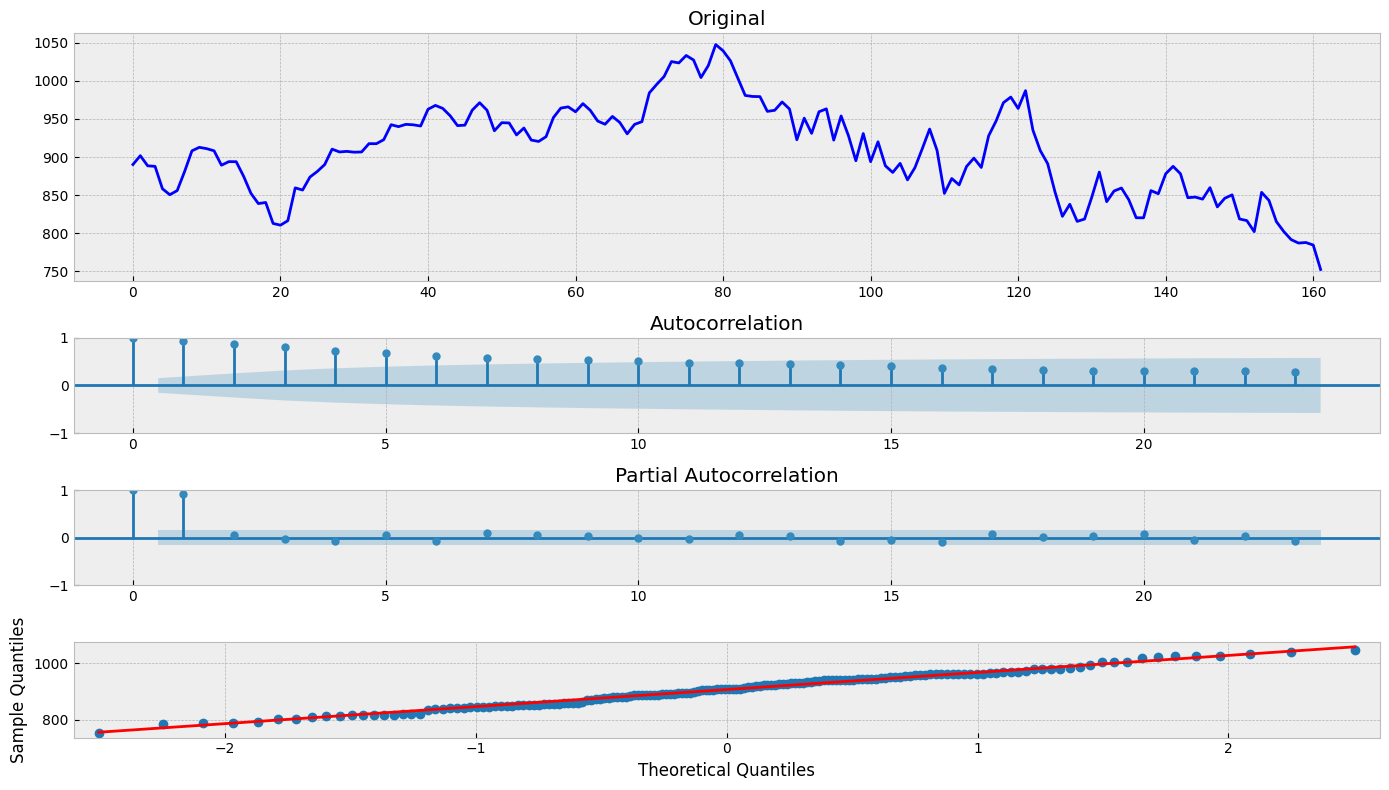

In [ ]:
tsplot(series)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(series, order=(i,d,j), trend='ct').fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 1431.33861 | order: (4, 0, 2)


Results of Dickey-Fuller Test:
Test Statistic                -1.282929e+01
p-value                        5.920755e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.610000e+02
Critical Value (1%)           -3.471633e+00
Critical Value (5%)           -2.879665e+00
Critical Value (10%)          -2.576434e+00
dtype: float64


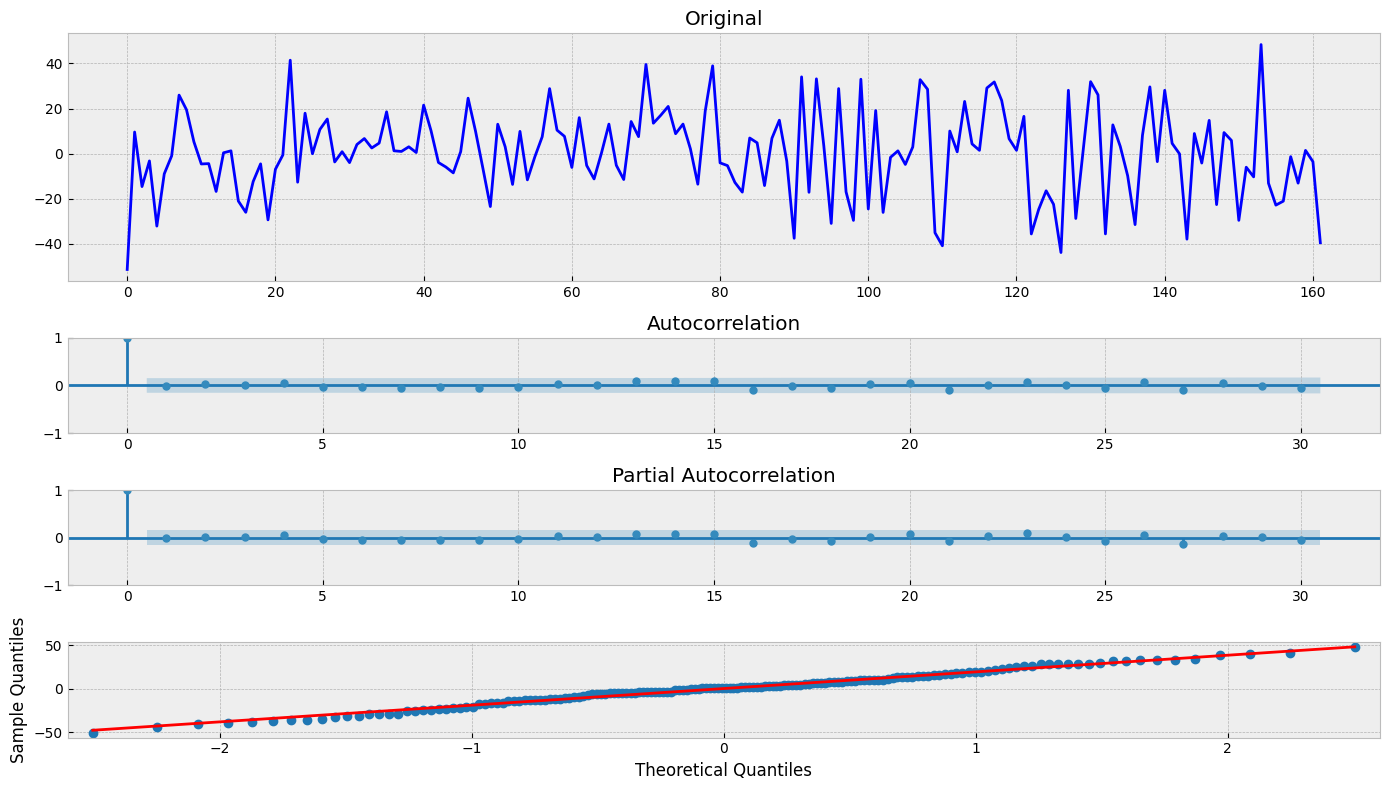

In [ ]:
tsplot(best_mdl.resid, lags=30)

In [ ]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  162
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -706.669
Date:                Fri, 29 Nov 2024   AIC                           1431.339
Time:                        11:15:41   BIC                           1459.127
Sample:                             0   HQIC                          1442.621
                                - 162                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        942.1169     56.146     16.780      0.000     832.072    1052.162
x1            -0.6207      0.498     -1.247      0.213      -1.597       0.355
ar.L1         -0.5258      0.125     -4.205      0.000      -0.771      -0.281
ar.L2          0.6408      0.068      9.474      0.000       0.508       0.773
ar.L3          0.8154      0.089      9.126      0.000       0.640       0.991
ar.L4         -0.1017      0.084     -1.208      0.227      -0.267       0.063
ma.L1          1.5248      0.103     14.864      0.000       1.324       1.726
ma.L2          0.8312      0.093      8.928      0.000       0.649       1.014
sigma2       353.7687     43.523      8.128      0.000     268.465     439.072
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.97   Prob(JB):                         0.79
Heteroskedasticity (H):               2.63   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

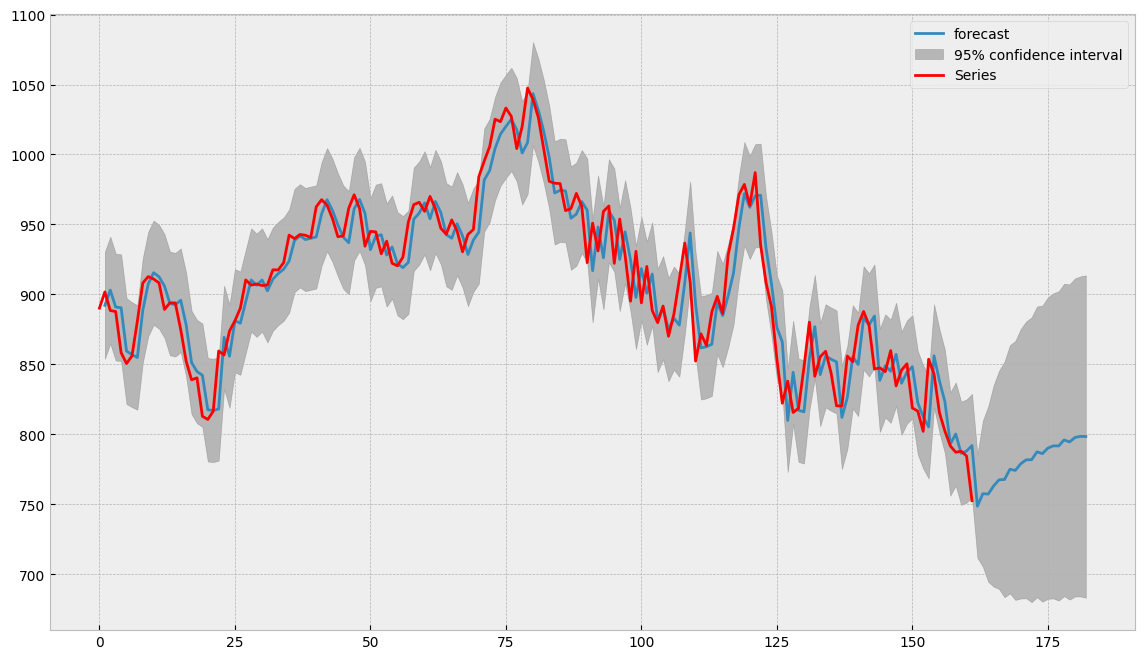

In [79]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()

    plot_predict(best_mdl, 1, len(series)+20, ax=ax)

    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()